## Data Loading & Initial Checks

Ensure data is correctly loaded and check for missing values.

In [20]:
import pandas as pd

# Load dataset
df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [21]:
# Check missing values
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [22]:
# Check data types
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


## Data Cleaning

Fixes missing values (TotalCharges has empty strings).

In [23]:
# Convert TotalCharges to numeric (empty strings → NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [24]:
# Fill missing values with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/var/folders/h8/7mdp3b1d7459pndz78blr7380000gq/T/ipykernel_47326/89892915.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


## Exploratory Data Analysis (EDA)

Identify patterns and correlations.

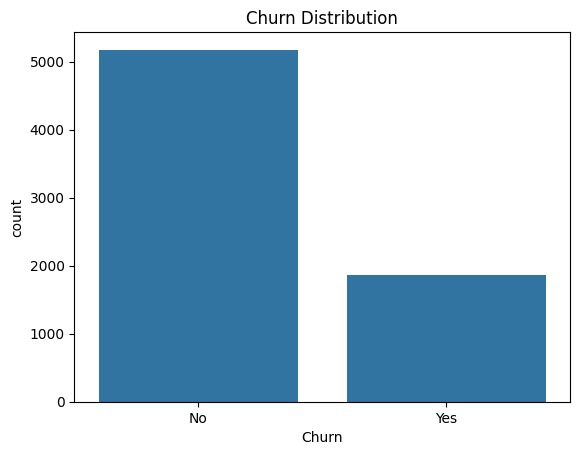

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

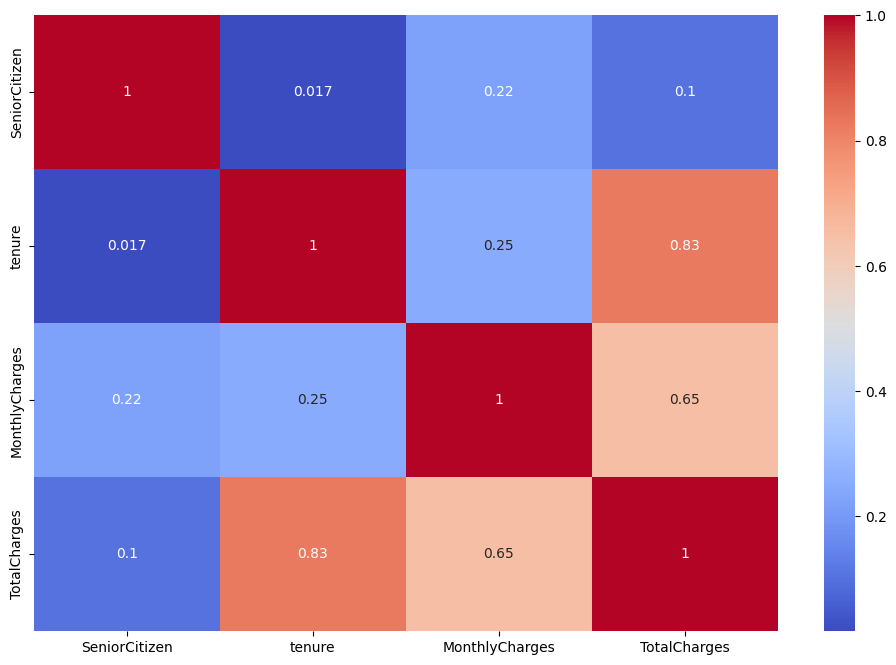

In [26]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

## Feature Engineering

Improves model performance by creating meaningful features.

In [27]:
# Convert categorical to numerical (One-Hot Encoding)
#df = pd.get_dummies(df, columns=['gender', 'InternetService', 'Contract'])

# Drop unnecessary columns
df.drop(['customerID'], axis=1, inplace=True)

## Model Building

Deep Learning can capture complex patterns

In [28]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = df.drop(columns=["Churn"])
y = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)  # Binary encoding

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
# Define preprocessing pipeline
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = ["gender",
    "SeniorCitizen", "Partner", "Dependents", 
    "PhoneService", "MultipleLines", "InternetService", "Contract",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "PaperlessBilling", "PaymentMethod"
]

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [31]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [33]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [35]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_processed).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_processed).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

In [36]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [37]:
# Define Neural Network Architecture
class ChurnClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ChurnClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Binary classification
        self.dropout = nn.Dropout(0.3)  # Regularization

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [38]:
# Initialize model
input_dim = X_train_processed.shape[1]
model = ChurnClassifier(input_dim).to(device)

In [39]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Training loop
for epoch in range(100):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 0.4383, Test Accuracy: 0.8062
Epoch 2, Loss: 0.0927, Test Accuracy: 0.8126
Epoch 3, Loss: 0.3350, Test Accuracy: 0.8105
Epoch 4, Loss: 0.7654, Test Accuracy: 0.8126
Epoch 5, Loss: 0.3215, Test Accuracy: 0.8091
Epoch 6, Loss: 0.0480, Test Accuracy: 0.8098
Epoch 7, Loss: 0.4225, Test Accuracy: 0.8112
Epoch 8, Loss: 0.0830, Test Accuracy: 0.8112
Epoch 9, Loss: 0.5315, Test Accuracy: 0.8084
Epoch 10, Loss: 0.4373, Test Accuracy: 0.8141
Epoch 11, Loss: 0.5565, Test Accuracy: 0.8169
Epoch 12, Loss: 1.1248, Test Accuracy: 0.8162
Epoch 13, Loss: 0.6408, Test Accuracy: 0.8162
Epoch 14, Loss: 0.1939, Test Accuracy: 0.8126
Epoch 15, Loss: 0.5701, Test Accuracy: 0.8119
Epoch 16, Loss: 0.2742, Test Accuracy: 0.8105
Epoch 17, Loss: 0.1007, Test Accuracy: 0.8133
Epoch 18, Loss: 0.2460, Test Accuracy: 0.8133
Epoch 19, Loss: 0.2380, Test Accuracy: 0.8141
Epoch 20, Loss: 0.1364, Test Accuracy: 0.8155
Epoch 21, Loss: 0.3608, Test Accuracy: 0.8112
Epoch 22, Loss: 0.0267, Test Accuracy: 0.81

## Hyperparameter Tuning (Optuna for PyTorch)

Optimizes model performance systematically.

In [46]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    n_units = trial.suggest_categorical("n_units", [32, 64, 128])

    # Initialize model with trial parameters
    model = ChurnClassifier(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop (simplified for brevity)
    for epoch in range(50):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Return validation accuracy
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        return accuracy



In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2025-05-14 18:32:17,436] A new study created in memory with name: no-name-5e0c51ff-eea2-48a4-a923-59546635a1a5
[I 2025-05-14 18:32:21,343] Trial 0 finished with value: 0.8105039034776437 and parameters: {'lr': 0.00010140583528130462, 'dropout_rate': 0.4142553933809192, 'n_units': 32}. Best is trial 0 with value: 0.8105039034776437.
[I 2025-05-14 18:32:25,257] Trial 1 finished with value: 0.8133427963094393 and parameters: {'lr': 1.027335092485985e-05, 'dropout_rate': 0.38369471360327934, 'n_units': 128}. Best is trial 1 with value: 0.8133427963094393.
[I 2025-05-14 18:32:29,161] Trial 2 finished with value: 0.8168914123491838 and parameters: {'lr': 0.00031751710756356045, 'dropout_rate': 0.3908718935542028, 'n_units': 32}. Best is trial 2 with value: 0.8168914123491838.
[I 2025-05-14 18:32:33,025] Trial 3 finished with value: 0.8133427963094393 and parameters: {'lr': 0.0005185941109268575, 'dropout_rate': 0.263989653843369, 'n_units': 64}. Best is trial 2 with value: 0.8168914123491

Best hyperparameters: {'lr': 0.00031751710756356045, 'dropout_rate': 0.3908718935542028, 'n_units': 32}


In [47]:
import joblib

# Save the fitted preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")
print("Preprocessor saved as 'preprocessor.pkl'")

# Train model 
torch.save(model.state_dict(), "model.pt")

print("Training complete. Preprocessor and model saved.")

Preprocessor saved as 'preprocessor.pkl'
Training complete. Preprocessor and model saved.
